# Team Lovelace : #TODO (ecrire le titre) <img src="../Data/Images/LinkedIn_logo_initials.png" width="25">

Welcome to our project notebook for Milestone P2! In this phase, our team has worked on refining our project proposal and conducting preliminary analyses to set the stage for a successful data exploration and analysis journey. 

Our project aims to create a LinkedIn network to analyze the careers of actors present in our dataset. In this milestone, we delve into initial analyses and data handling tasks, ensuring that our proposed project is feasible given the available datasets.

## Imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

## Loading Datasets

In [2]:
# Setting the paths to the data folders
DATA_FOLDER = "../Data/"
CMU_PATH = DATA_FOLDER + "MovieSummaries/"
IMDB_PATH = DATA_FOLDER + "IMDb/"

# Reading CMU Movie & Character metadata
cmu_movies_raw = pd.read_csv(CMU_PATH + "movie.metadata.tsv", sep="\t")
cmu_characters_raw = pd.read_csv(CMU_PATH + "character.metadata.tsv", sep="\t")


# Reading IMDb basics and ratings data
imdb_movies_raw = pd.read_csv(
    IMDB_PATH + "title.basics.tsv.gz", sep="\t", compression="gzip"
)
imdb_ratings_raw = pd.read_csv(
    IMDB_PATH + "title.ratings.tsv.gz", sep="\t", compression="gzip"
)

# TODO Import other dataset (Don't forget to add comments as above)

### Renaming Columns

Both CMU datasets, `cmu_movies_raw` and `cmu_characters_raw`, initially lacked column names (#TODO ajouter les noms des autres datasets entre `...` si nécessaires). To address this, we have provided names in the cell below. For the CMU dataset, you can refer to the descriptions of each column [here](http://www.cs.cmu.edu/~ark/personas/). (#TODO pareil mettre les liens pour les autres datasets)


In [3]:
cmu_movies_raw.columns = [
    "wikiID",
    "fbID",
    "name",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

cmu_characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "actorDOB",
    "actorGender",
    "actorHeight",
    "actorEthnicity",
    "actorName", #TODO est-ce qu'on laisse name ou on met actorName, actorDOB, and so on...
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

#TODO add les noms ici si necessaire pour les autres datasets

To ensure consistency in column names across datasets, we have renamed some columns in the other datasets (to match the conventions of the CMU dataset) in the cell below.

In [4]:
imdb_movies_raw.rename(
    columns={
        "tconst": "imdbID", 
        "primaryTitle": "name",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

imdb_ratings_raw.rename(
    columns={
        "tconst": "imdbID", 
    },
    inplace=True
)

# TODO rename les columns des autres datasets si nécessaire

## Merging Datasets

Before merging the datasets, it is important to clean and standardize the column formats for the columns we intend to merge on. To facilitate this process, we create copies of our raw dataframes. This ensures that we don't need to reload them if we want to start the cleaning process from scratch.

In [147]:
cmu_movies = cmu_movies_raw.copy()
cmu_characters = cmu_characters_raw.copy()

imdb_movies = imdb_movies_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

### Cleaning column `name`

#TODO Michael explain why et comment tu le fais pour les deux datasets cmu movies et imdb et autres

In [6]:
# cleaning titles #TODO

### Cleaning column `releaseDate`

The `cmu_movies` and `cmu_characters` dataset exhibit variable date formats, with some entries providing day, month, and year, while others only contain the year. To enhance clarity and facilitate analysis, we've decided to split the `releaseDate` column into separate columns for `releaseMonth` and `releaseYear`. In contrast, the `imdb_movies` dataset provides release dates in the year-only format.

In [148]:
cmu_movies["releaseMonth"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", dayfirst=True
).dt.month

cmu_movies["releaseYear"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

cmu_movies.drop(columns=["releaseDate"], inplace=True)

cmu_characters["releaseMonth"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", yearfirst=True
).dt.month

cmu_characters["releaseYear"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

cmu_characters.drop(columns=["releaseDate"], inplace=True)

imdb_movies["releaseYear"] = pd.to_datetime(
    imdb_movies["releaseYear"], errors="coerce", format="%Y"
).dt.year

### Cleaning column `runtime`

The `runtime` column for the `imdb_movies` dataset contains '\N' values instead of 'NaN'.

In [8]:
imdb_movies.runtime = pd.to_numeric(imdb_movies.runtime, errors="coerce")

#TODO other columns to clean pour merger??

In [9]:
#TODO

### Merging

In the subsequent cells, we perform two left merges:

1. **IMDb Movies and IMDb Ratings:**
   - We merge the `imdb_movies` and `imdb_ratings` datasets based on the common column "imdbID" using a left join.


2. **CMU Movies and IMDb Merged Data:**
   - We merge the `cmu_movies` dataset with the previously merged IMDb dataset based on the common columns `["name", "releaseYear", "runtime"]`. The resulting DataFrame, named `movies_merged`, contains combined information from both datasets, with column suffixes "Cmu" for columns from the CMU dataset and "Imdb" for columns from the IMDb dataset.


In [10]:
imdb_merged = pd.merge(    
    imdb_movies,
    imdb_ratings,
    how="left",
    on="imdbID")

movies_merged = pd.merge(
    cmu_movies,
    imdb_merged,
    how="left",
    on=["name", "releaseYear", "runtime"],
    suffixes=["Cmu", "Imdb"],
)

In [11]:
# TODO other merge to do. Adapter les textes au dessus et il faut max deux datasets. 
# un qui s'appelle actors et l'autre movies

As before, we copy our DataFrame to avoid running the merge cell in case we make modifications incorrectly and wish to restart from this point.

In [128]:
movies = movies_merged.copy()

## Cleaning the columns

### Genres 

The `genresCmu` column, while having very few missing values, exhibits a wide diversity of genres, as outlined in the cell below. Additionally, the genres are not standardized; for instance, we observe distinctions like 'Action', 'Adventure' and 'Action/Adventure' making it challenging to analyze. As for `genresImdb`, we have a reasonably manageable number of unique genres. However, due to the merge, we notice a considerable number of missing values compared to `genresCmu`.

In [129]:
# Updating the 'genresCmu' and 'genresImdb' columns to get a list of genres without the IDs for each movie
movies['genresCmu'] = movies['genresCmu'].apply(parse_dict)
movies['genresImdb'] = movies['genresImdb'].apply(
    lambda x: x.split(',') if not (isinstance(x, float) or x=="\\N") else np.nan)

In [130]:
percent_missing = movies.isnull().sum() * 100 / len(movies)
print(
    f"Proportion of missing values in each column:\n{ percent_missing[['genresCmu', 'genresImdb']]}"
)

number_genres_cmu = len(movies.genresCmu.explode().unique())
number_genres_imdb = len(movies.genresImdb.explode().unique())
print("\nNumber of unique genres in\n"+ 
      "CMU:",number_genres_cmu,"\n"
      "Imdb:", number_genres_imdb)

Proportion of missing values in each column:
genresCmu      2.932897
genresImdb    62.216394
dtype: float64

Number of unique genres in
CMU: 364 
Imdb: 29


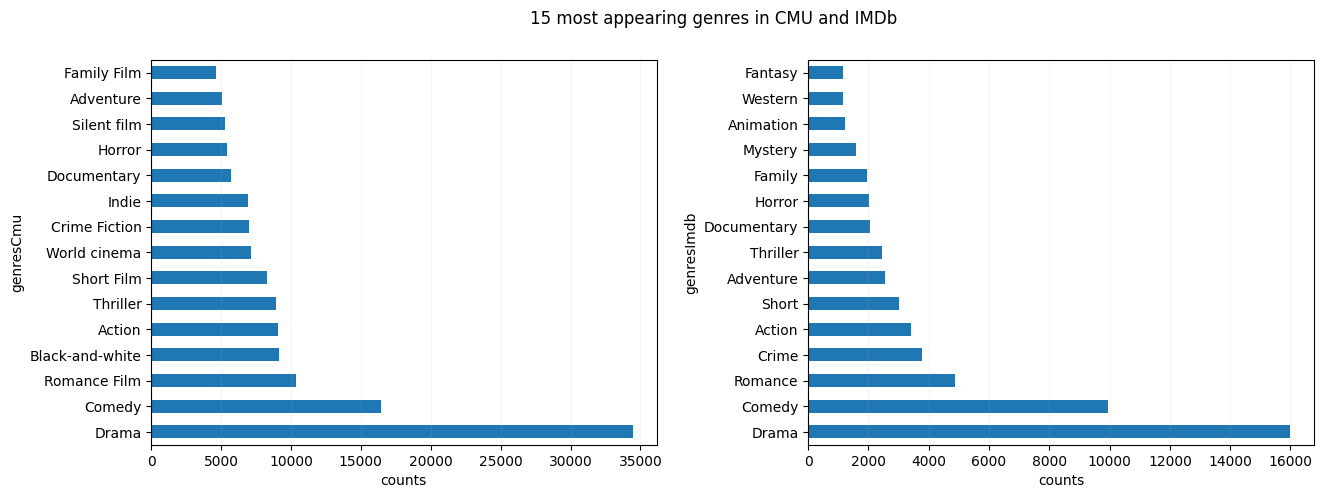

In [131]:
fig = plt.figure(figsize=(15,5))
fig.suptitle( "15 most appearing genres in CMU and IMDb")

fig.add_subplot(121)
occurences_cmu = movies["genresCmu"].explode().value_counts()
occurences_cmu[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

fig.add_subplot(122)
occurences_imdb = movies["genresImdb"].explode().value_counts()
occurences_imdb[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

plt.subplots_adjust(wspace=0.3)

To address the issue of numerous missing values in 'Imdb' and the diversity of genres in 'CMU', we will first combine the genres for each movie.

In [132]:
combinedGenres = movies["genresImdb"].apply(
    lambda x: list(x) if isinstance(x, list) else []
) + movies["genresCmu"].apply(lambda x: list(x) if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x) > 0 else np.nan)

movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0         {Crime Drama, Biographical film, Drama, Mystery}
1                            {Crime, Crime Fiction, Drama}
2        {Erotic thriller, Thriller, Psychological thri...
3                                                  {Drama}
4        {Silent film, Short Film, Black-and-white, Com...
                               ...                        
83121                                              {Drama}
83122              {Documentary, Biographical film, Drama}
83123                                     {Comedy, Satire}
83124    {Animation, Adventure, Short Film, Anime, Dram...
83125                    {Horror, Thriller, Teen, Slasher}
Name: combinedGenres, Length: 83126, dtype: object

Once we have a set of unique genres for each movie, the idea is to create a long string by concatenating all the genres for all the movies.

In [133]:
genres = movies.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_str = " ".join(str(g) for g in genres)

genres_unique = np.unique(genres)

Then we want to split this long string using the `split_characters` found by the code. This will, for example, allow us to split the genre 'Action/Adventure' into 'Adventure' and 'Action'. The list `words` contains all the words appearing throughout all the combinedGenres. The more a word appears in the list `words`, the more it appears in combinedGenres.

In [134]:
split_characters = set()
for letter in genres_str:
    if not letter.isalpha() and letter != " ": # letter.isalpha() return True if the letter is an alphabetic string
        split_characters.add(letter)

print(split_characters)

string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))
    
words = string.split(" ")
print("\nThe first 15 terms of the list words",words[:15])


{"'", '[', '5', '/', ']', '&', '9', '-'}

The first 15 terms of the list words ['Crime', 'Drama', 'Biographical', 'film', 'Drama', 'Mystery', 'Crime', 'Crime', 'Fiction', 'Drama', 'Erotic', 'thriller', 'Thriller', 'Psychological', 'thriller']


Now, our objective is to identify the most frequently occurring words in our list of `words`. As one can observe above, some words are presented in uppercase, while others are in lowercase. To ensure consistency, we convert all text to lowercase and proceed to identify words that appear more than 2000 times. 

In [135]:
words = list(map(lambda x: x.lower(), words)) 

counts = pd.Series(words).value_counts()
new_genres_serie = pd.Series(counts[counts > 2000])
new_genres_serie.index

Index(['drama', 'film', 'comedy', 'action', 'romance', 'crime', 'thriller',
       'adventure', 'short', 'fiction', 'black', 'and', 'white', 'family',
       'cinema', 'world', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'movies', 'fantasy', 'animation', 'mystery', 'war',
       '', 'science', 'movie', 'western', 'japanese', 'biography'],
      dtype='object')

Finally, we have a list of words representing our new genres. After filtering out words that do not correspond to actual genres, we create a dictionary, `genres_dict`, linking genres from 'CMU' and 'IMDb' to our new list of genres. For example, all genres containing the word 'drama' will be associated with the genre 'Drama.' 

A list of genres associated with 'Drama' is displayed two cells below.

In [136]:
# Dropping irrelevant genres and characters from the series
new_genres_serie = new_genres_serie.drop(index=[
    "", 
    "film",
    "cinema",
    "movie",
    "black",
    "and", 
    "white",  # combining "black-and-white" instead of having separate entries
    "science",   
])

# Adding "black-and-white" to the indices
new_genres_serie["black-and-white"] =0

# Capitalizing the new genres and create a list from the indices 
new_genres = list(map(lambda x:x.capitalize(), new_genres_serie.index))

genres_dict = {genre: set() for genre in new_genres}
for new_genre in new_genres:
    for genre in genres_unique:
        if new_genre.lower() in genre.lower():
            genres_dict[new_genre].add(genre)

# Merging "Romantic" into "Romance" since can be considered equivalent 
genres_dict["Romance"] = genres_dict["Romance"].union(genres_dict.pop("Romantic"))
new_genres.remove("Romantic")

print(len(new_genres),"unified genres listed below")
new_genres

25 unified genres listed below


['Drama',
 'Comedy',
 'Action',
 'Romance',
 'Crime',
 'Thriller',
 'Adventure',
 'Short',
 'Fiction',
 'Family',
 'World',
 'Indie',
 'Horror',
 'Documentary',
 'Silent',
 'Musical',
 'Movies',
 'Fantasy',
 'Animation',
 'Mystery',
 'War',
 'Western',
 'Japanese',
 'Biography',
 'Black-and-white']

In [137]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In conclusion to the cleaning process, we apply the function `unify_genres()` to our column combinedGenres, creating the new unique column genres. This transformation ensures that the genres are now meaningful for our analysis.

Proportion of missing values in column genres 3.72%


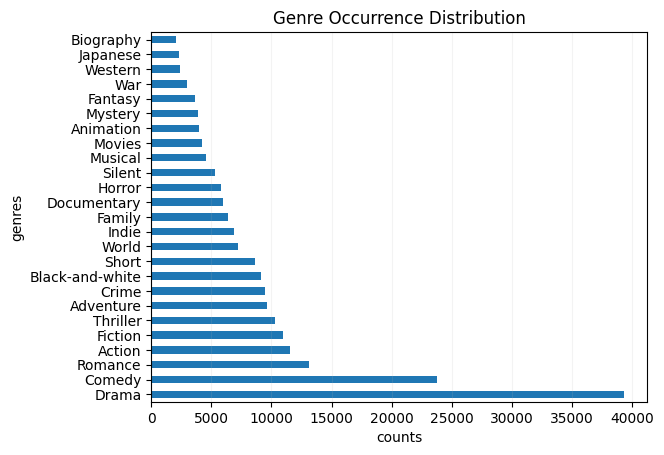

In [144]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in new_genres if genre in genres_dict[t]}
            unified_genres= unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError: 
        return x
    
movies["genres"] = movies["combinedGenres"].apply(unify_genres)
# movies.drop(columns=["genresCmu","genresImdb","combinedGenres"],inplace=True) #TODO uncomment 

occurences = movies["genres"].explode().value_counts()
occurences.plot(kind='barh')
plt.title("Genre Occurrence Distribution")
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

percent_missing = movies["genres"].isnull().sum()/ len(movies)
print(f"Proportion of missing values in column genres {percent_missing:.2%}")

## Saving Preprocessed Datasets

### Removing Unnecessary Columns

We are excluding columns containing information irrelevant to our analysis from all datasets to optimize memory usage and enhance readability.

In [139]:
# TODO enlever toutes les columns qu'on utilise pas dans TOUS les datasets

In [140]:
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

NameError: name 'actors' is not defined

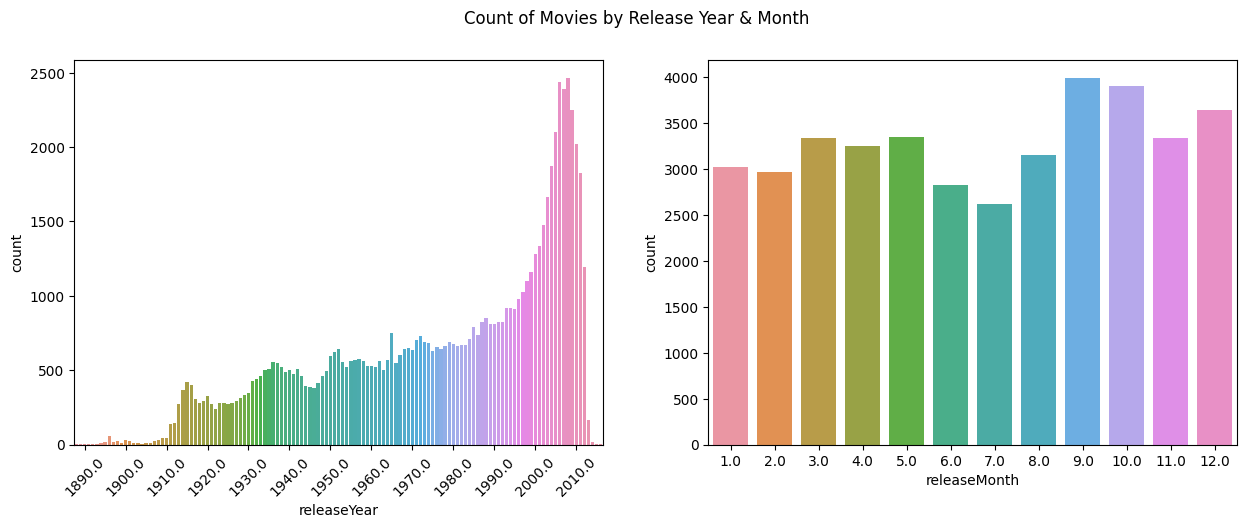

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Count of Movies by Release Year & Month')

fig.add_subplot(121)
sns.countplot(x='releaseYear', data=cmu_movies) 
plt.xticks(plt.xticks()[0][2::10], rotation=45)

fig.add_subplot(122)
sns.countplot(x="releaseMonth", data=cmu_movies)

plt.subplots_adjust(wspace=0.2)
plt.show()